##### EEEL 4220 Final Project
## Wind Farm Sizing and Siting on IEEE-14 System

4. 14-bus 5-scenario, with wind planning. Finally, assemble all scenarios together to produce the full planning model.

In [54]:
# Import libraries
import cvxpy as cp
import numpy as np
import pandas as pd

In [55]:
# Load data
b_df = pd.read_csv('buses.csv')
g_df = pd.read_csv('generators.csv')
l_df = pd.read_csv('branches.csv')
d_df = pd.read_csv('demand_scenarios.csv')
cfs_df = pd.read_csv('wind_cf_scenarios.csv')
y_df = pd.read_csv('wind_candidates.csv')

In [ ]:
# cvxpy parameters
candidates = cp.Parameter(nonneg=True, value=len(y_df)) # Discrete siting - number of sites allowed
Cinv = cp.Parameter(value=1.5) # investment cost per MW of installed wind capacity ($/MW)

# Parameters
c2 = g_df['c2'].to_numpy().reshape(1,-1) # quadratic cost coefficients for generator g
c1 = g_df['c1'].to_numpy().reshape(1,-1) # linear cost coefficients for generator g
c0 = g_df['c0'].to_numpy().reshape(1,-1) # fixed cost coefficients for generator g
Pmin = g_df['Pmin_MW'].to_numpy().reshape(-1,1) # minimum generation limits for generator g
Pmax = g_df['Pmax_MW'].to_numpy().reshape(-1,1) # maximum generation limits for generator g
x = l_df['x_pu'].to_numpy().reshape(-1,1) # reactance of transmission line l
fmax = l_df['rateA_MW'].to_numpy().reshape(-1,1) # thermal limit of line l
D = d_df.pivot(index='bus_id',columns='scenario_id',values='Pd_MW').to_numpy() # demand at bus b in scenario s
CF = cfs_df['capacity_factor'].to_numpy().reshape(1,-1) # wind capacity factor in scenario s
omega = cfs_df['probability'].to_numpy() # probability (weight) of scenario s
ybar = pd.merge(b_df, y_df, on='bus_id', how='left')['max_capacity_MW'].fillna(0).to_numpy().reshape(-1,1) # maximum installable wind capacity at bus b (0 if not candidate)

# Decision variables
p = cp.Variable((len(g_df), len(cfs_df)), nonneg=True) # ps = power output of generator g under scenario s
f = cp.Variable((len(l_df), len(cfs_df))) # fs = power flow on line l under scenario s
theta = cp.Variable((len(b_df), len(cfs_df))) # thetas = voltage angle at bus b (radians)
w = cp.Variable((len(b_df), len(cfs_df)), nonneg=True) # ws = wind generation at bus b under scenario s
y = cp.Variable((len(b_df),1), nonneg=True) # installed wind capacity at bus b (MW)
z = cp.Variable((len(b_df),1), boolean=True) # zb = 1 if wind installed at bus b, 0 otherwise

In [57]:
# Initialize incidence matrices
# Generator–bus
# Ggb = 1 if generator g is connected to bus b, 0 otherwise.
G = np.zeros((len(g_df), len(b_df)))

# Line–bus
# Alb = 1 if bus b is the sending (“from”) end of line l, if bus b is the receiving (“to”) end of line l, 0 otherwise.
A = np.zeros((len(l_df), len(b_df)))

# Populate incidence matrices
# Generator–bus
for gen_index in range(len(g_df)):
    bus_id = g_df.loc[gen_index, 'bus_id']
    bus_index = bus_id - 1
    G[gen_index, bus_index] = 1

# Line–bus
for line_index in range(len(l_df)):
    from_bus_id = l_df.loc[line_index, 'from_bus']
    to_bus_id = l_df.loc[line_index, 'to_bus']
    from_bus_index = from_bus_id - 1
    to_bus_index = to_bus_id - 1
    A[line_index, from_bus_index] = 1
    A[line_index, to_bus_index] = -1

In [ ]:
# Define constraints
# Initialize an empty constraint set
con = [] 

# power balance
con.append((A.T @ f) + D == (G.T @ p) + w)

# generator output limits
con.append(p <= Pmax)  # maximum generation

# set reference angle
con.append(theta[0] == 0)

# DC power flow
con.append(f == (A @ theta) / x)

# line flow limits
con.append(f <= fmax)  # maximum line flow
con.append(f >= -fmax)  # minimum line flow
# wind generation limits
con.append(w <= y @ CF)  # wind generation cannot exceed installed capacity

# wind capacity limits
con.append(y <= ybar)  # maximum installed capacity

# discrete siting constraint
con.append(y <= cp.multiply(z, ybar))
con.append(sum(z) <= candidates)  # only 1 bus allowed

# Define objective function
obj = cp.Minimize((c2 @ p**2 + c1 @ p + c0) @ omega + (Cinv * sum(y)))

# Define problem
prob = cp.Problem(obj, con)

In [ ]:
# Choose number of sites to allow and solve problem
candidates.value = 4
Cinv.value = 2.5
prob.solve(solver = "SCIP");

In [65]:
# Convert results to df
IWT = y.value.round(1)
GT = p.value.round(1)
WT = w.value.round(1)
LT = f.value.round(1)
# MCT = (con[0].dual_value / omega).round(1)

IWT = pd.DataFrame(IWT, index = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14'],
                  columns=['Installed_Capacity_MW'])
# MCT = pd.DataFrame(MCT, index = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14'],
#                   columns=['S1', 'S2', 'S3', 'S4', 'S5'])
GT = pd.DataFrame(GT, index = ['G1', 'G2', 'G3', 'G4', 'G5'], 
                  columns=['S1', 'S2', 'S3', 'S4', 'S5'])
WT = pd.DataFrame(WT[[1,4,8,12],:], index=['B2','B5','B9','B13'], columns=['S1','S2','S3','S4','S5'])
LT = pd.DataFrame(LT, index = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20'], 
                  columns=['S1', 'S2', 'S3', 'S4', 'S5'])

# Print results
print("Total generation in the system for each scenario:")
print((GT.sum(axis=0) + WT.sum(axis=0)).round(1).to_list())
print("\n Total demand in the system for each scenario:") 
print(D.sum(axis=0).round(1))

print("\n System Total Cost: ")
print(round(obj.value, 1))

print("\n Cost savings: ")
print((839.9 - obj.value))

print("Total wind generation:")
print((WT.sum(axis=0)).round(1))

print("Emissions reductions:")
print((WT.sum(axis=0)*1000*500).round(1))

print("Expected emissions reductions:")
print((WT.sum().sum()*1000*500*0.2).round(1))

print("\n Installed wind capacity results: ")
print(IWT.round(1))

print("\n Thermal generator dispatch results: ")
print(GT.round(1))

print("\n Wind dispatch results: ")
print(WT.round(1))

print("\n Line flow results: ")
print(LT.round(1))

# print("\n Locational Marginal Prices: ")
# print(MCT.round(1))

Total generation in the system for each scenario:
[233.1, 259.0, 284.9, 246.1, 272.0]

 Total demand in the system for each scenario:
[233.1 259.  284.9 246.  271.9]

 System Total Cost: 
839.9

 Cost savings: 
0.01883178915352346
Total wind generation:
S1    0.0
S2    0.0
S3    0.0
S4    0.0
S5    0.0
dtype: float64
Emissions reductions:
S1    0.0
S2    0.0
S3    0.0
S4    0.0
S5    0.0
dtype: float64
Expected emissions reductions:
0.0

 Installed wind capacity results: 
     Installed_Capacity_MW
B1                     0.0
B2                     0.0
B3                     0.0
B4                     0.0
B5                     0.0
B6                     0.0
B7                     0.0
B8                     0.0
B9                     0.0
B10                    0.0
B11                    0.0
B12                    0.0
B13                    0.0
B14                    0.0

 Thermal generator dispatch results: 
      S1    S2    S3    S4    S5
G1  79.1  88.4  97.8  83.8  93.1
G2  42.9  47.

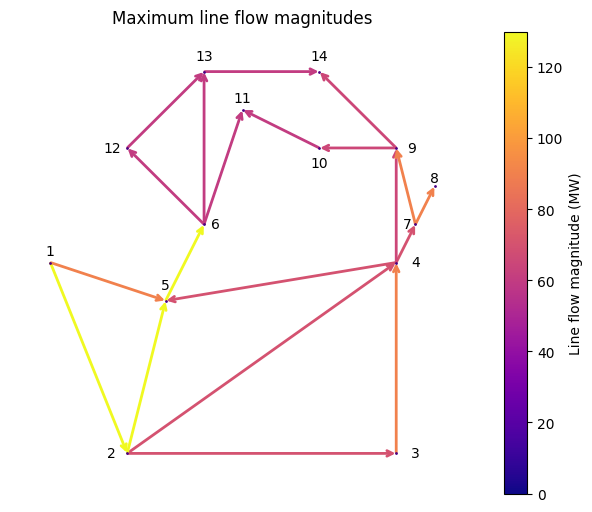

/opt/anaconda3/envs/PyEnv/lib/python3.13/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


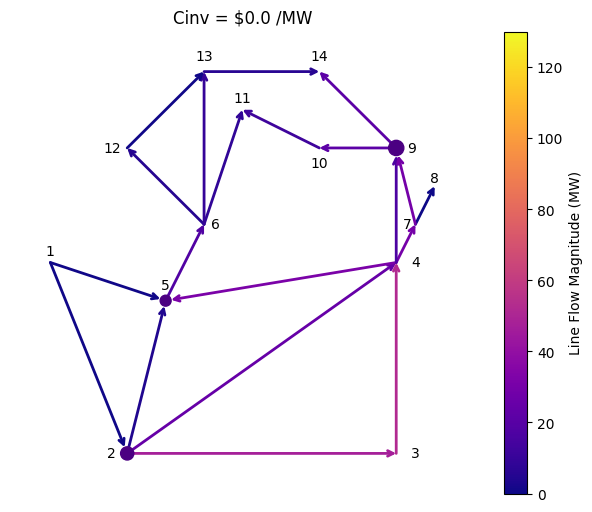

/opt/anaconda3/envs/PyEnv/lib/python3.13/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


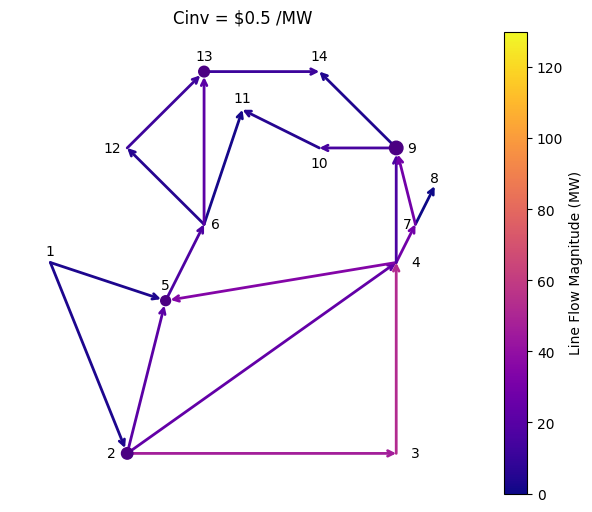

/opt/anaconda3/envs/PyEnv/lib/python3.13/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


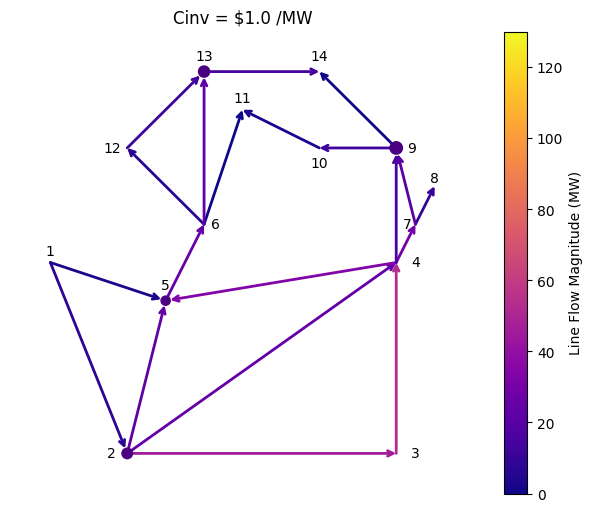

/opt/anaconda3/envs/PyEnv/lib/python3.13/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


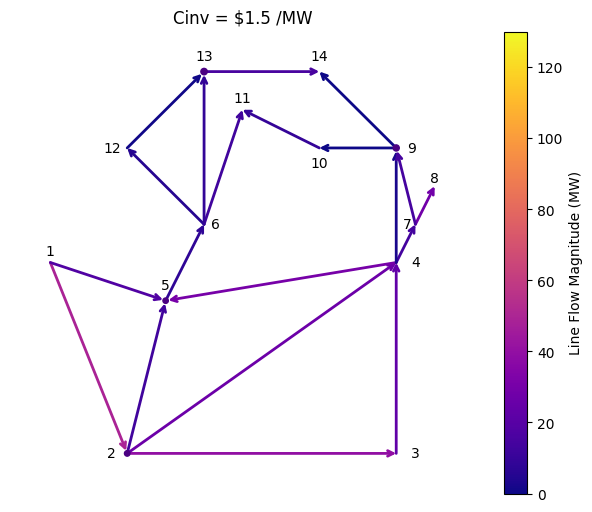

/opt/anaconda3/envs/PyEnv/lib/python3.13/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


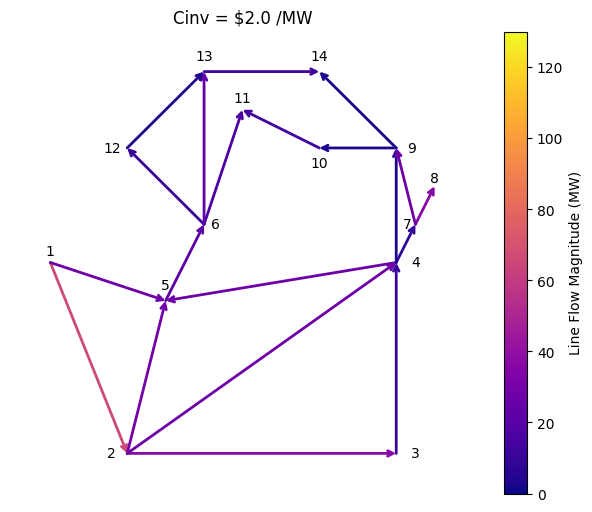

/opt/anaconda3/envs/PyEnv/lib/python3.13/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


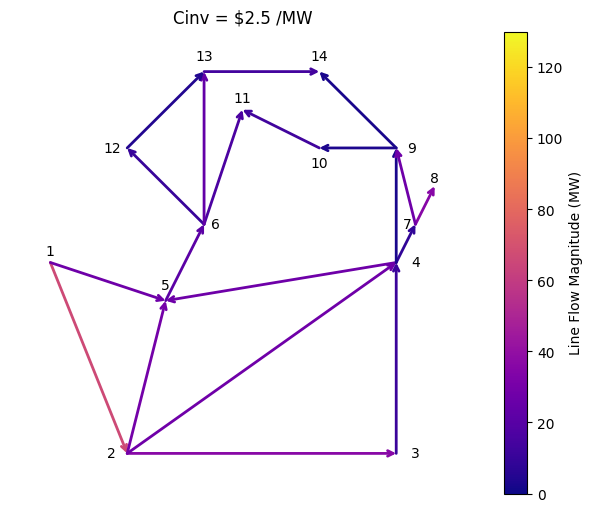

,Cinv,Total Cost ($),Total installed wind capacity (MW)
0,0.0,161.947949,590.000000
1,0.5,455.010395,569.800000
2,1.0,695.506606,408.750241
3,1.5,827.712292,118.990566
4,2.0,839.881167,0.000000
5,2.5,839.881167,0.000000


Text(0.5, 1.0, 'System Total Cost, Installed Wind Capacity vs. Wind Investment Cost')

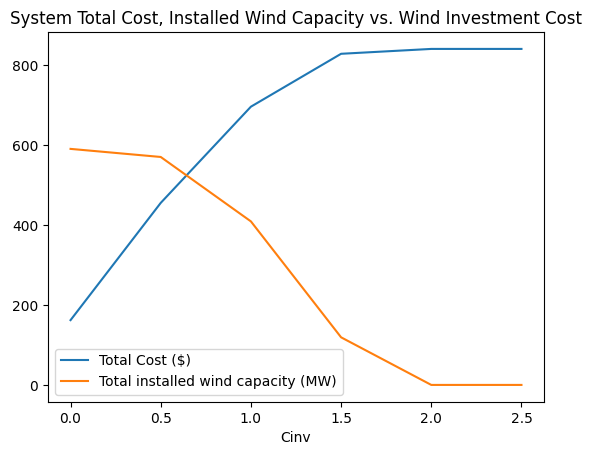

In [61]:
# Visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

# Total cost - Cinv relationship - initialize dataframes
cinv_all = np.arange(0,2.6,0.5)
cols = ["Cinv", "Total Cost ($)", "Total installed wind capacity (MW)"]
results_df  = pd.DataFrame(np.zeros(shape=(len(cinv_all),3)),columns=cols)
results_df["Cinv"] = cinv_all

# Graph network flow
G = nx.DiGraph()

G.add_nodes_from(b_df['bus_id'].to_list())
G.add_edges_from(l_df[['from_bus', 'to_bus']].apply(tuple, axis=1).to_list())
pos = {
        1: (0, 5),
        2: (2, 0),
        3: (9, 0),
        4: (9, 5),
        5: (3, 4),
        6: (4, 6),
        7: (9.5, 6),
        8: (10, 7),
        9: (9, 8),
        10: (7, 8),
        11: (5, 9),
        12: (2, 8),
        13: (4, 10),
        14: (7, 10),
    }
pos_labels = {
        1: (0, 5.3),
        2: (1.6, 0),
        3: (9.5, 0),
        4: (9.5, 5),
        5: (3, 4.4),
        6: (4.3, 6),
        7: (9.3, 6),
        8: (10, 7.2),
        9: (9.4, 8),
        10: (7, 7.6),
        11: (5, 9.3),
        12: (1.6, 8),
        13: (4, 10.4),
        14: (7, 10.4),
    }

flow_scenario = 5
candidates.value = 4

# Graph max line flows
fig, ax = plt.subplots(figsize=(7.5, 6))
node_sizes = 1
edge_colors = l_df['rateA_MW'].to_numpy()#fmax.reshape(1,-1)[0,:]
norm = mpl.colors.Normalize(vmin=0, vmax=130)
edge_colors_normalized = [cmap(norm(val)) for val in edge_colors]
cmap = plt.cm.plasma

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo", ax=ax)
labels = {node: str(node) for node in G.nodes()}
labels = nx.draw_networkx_labels(G, pos_labels, labels, font_size=10, font_color='black', ax=ax)
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors_normalized,
    edge_cmap=cmap,
    width=2
)

norm = mpl.colors.Normalize(vmin=0, vmax=130)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(edge_colors)
plt.colorbar(sm, ax=ax, label='Line flow magnitude (MW)')

ax.set_axis_off()
plt.title("Maximum line flow magnitudes")
plt.show()

for c in cinv_all:
    candidates.value = 1
    Cinv.value = c
    prob.solve(solver = "SCIP");

    # Add cost and installation results to dfs
    results_df.loc[results_df["Cinv"] == c,"Total Cost ($)"] = obj.value
    results_df.loc[results_df["Cinv"] == c,"Total installed wind capacity (MW)"] = y.value.sum()

    # Get wind dispatch and line flow results
    WT = w.value
    LT = f.value
    # Graph line flows
    fig, ax = plt.subplots(figsize=(7.5, 6))
    node_sizes = WT[:,flow_scenario-1].round(1)
    edge_colors = np.abs(LT[:,flow_scenario-1].round(1))
    norm = mpl.colors.Normalize(vmin=0, vmax=130)
    edge_colors_normalized = [cmap(norm(val)) for val in edge_colors]
    cmap = plt.cm.plasma

    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo", cmap=cmap, ax=ax)
    labels = {node: str(node) for node in G.nodes()}
    labels = nx.draw_networkx_labels(G, pos_labels, labels, font_size=10, font_color='black', ax=ax)
    edges = nx.draw_networkx_edges(
        G,
        pos,
        node_size=node_sizes,
        arrowstyle="->",
        arrowsize=10,
        edge_color=edge_colors_normalized,
        edge_cmap=cmap,
        width=2
    )

    norm = mpl.colors.Normalize(vmin=0, vmax=130)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(edge_colors)
    plt.colorbar(sm, ax=ax, label='Line Flow Magnitude (MW)')

    ax.set_axis_off()
    plt.title("Cinv = $" + str(c) + " /MW")
    plt.show()


display(results_df)

plt.plot(results_df["Cinv"], results_df["Total Cost ($)"], label=cols[1])
plt.plot(results_df["Cinv"], results_df["Total installed wind capacity (MW)"], label=cols[2])
plt.xlabel(cols[0])

plt.legend()
plt.title("System Total Cost, Installed Wind Capacity vs. Wind Investment Cost")